In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
sns.set(font_scale=2, style="whitegrid")
sns.set_theme(rc={'figure.dpi':100})
                  
from sade.sde_lib import VESDE
from tqdm import tqdm
from sade.ood_detection_helper import *


[1713366344.549780] [fa79a04240ba:41496:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


In [3]:
from sade.configs.ve import biggan_config
config = biggan_config.get_config()
config.data

cache_rate: 0.0
dataset: ABCD
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
spacing_pix_dim: 2.0
splits_dir: /codespace/sade/sade/datasets/brains/

In [4]:
# Setup SDE
from sade.models.registry import create_sde, get_msma_sigmas

sde = create_sde(config)

num_scales = config.model.num_scales 
n_timesteps=config.msma.n_timesteps
config.msma.min_timestep = eps = 0.01
config.msma.max_timestep = 0.8
t=torch.linspace(eps, 1.0, num_scales, device="cpu")
sigmas = sde.marginal_prob(torch.zeros_like(t), t)[1].numpy()

# exact_sigmas = np.array([sigmas[i] for i in range(0,num_scales,num_scales//n_timesteps)])
# geometric_sigmas = torch.exp(
#             torch.linspace(
#                 np.log(sde.sigma_min),
#                 np.log(sde.sigma_max),
#                 config.msma.n_timesteps,
#                 device=config.device,
#             )
# )
# timesteps = sde.noise_schedule_inverse(geometric_sigmas)

timesteps = get_msma_sigmas(config)
geometric_sigmas = sde.marginal_prob(torch.zeros(num_scales), timesteps)[1]

recordify = lambda ds,name: [(i, geometric_sigmas[i].item(), x, name) for i, scores in enumerate(ds.T) for x in scores ]
timesteps

2024-04-17 15:05:48.123313: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 15:05:48.125510: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 15:05:48.159856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensor([0.0100, 0.0516, 0.0932, 0.1347, 0.1763, 0.2179, 0.2595, 0.3011, 0.3426,
        0.3842, 0.4258, 0.4674, 0.5089, 0.5505, 0.5921, 0.6337, 0.6753, 0.7168,
        0.7584, 0.8000])

In [5]:
geometric_sigmas

tensor([6.5725e-02, 9.6009e-02, 1.4025e-01, 2.0487e-01, 2.9926e-01, 4.3715e-01,
        6.3857e-01, 9.3281e-01, 1.3626e+00, 1.9904e+00, 2.9076e+00, 4.2473e+00,
        6.2043e+00, 9.0629e+00, 1.3239e+01, 1.9339e+01, 2.8249e+01, 4.1266e+01,
        6.0279e+01, 8.8054e+01])

### ABCD Lesion Experiment

In [6]:
ckpt=1500002
exp = "abcd-val_ibis-inlier_ibis-ds-sa"
fname=f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/ckpt_1500002/smin=0.01_smax=0.80_t=20/{exp}_results.npz"
 
with np.load(fname, allow_pickle=True) as data:
    abcd_eval_score_norms = data["eval_score_norms"]
    ibis_inlier_score_norms = data["inlier_score_norms"]
    ibis_ds_score_norms = data["ood_score_norms"]
    original_results = data["results"].item()
    
abcd_eval_score_norms.shape, ibis_inlier_score_norms.shape, ibis_ds_score_norms.shape

((165, 20), (101, 20), (28, 20))

In [7]:
exp = "ibis-inlier_ibis-hr-inlier_ibis-atypical"
fname=f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/ckpt_1500002/smin=0.01/{exp}_results.npz"

with np.load(fname, allow_pickle=True) as data:
    ibis_hr_inlier_score_norms = data["inlier_score_norms"]
    ibis_atypical_score_norms = data["ood_score_norms"]

    
exp = "ibis-inlier_ibis-hr-inlier_ibis-asd"
fname=f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/ckpt_1500002/smin=0.01/{exp}_results.npz"

with np.load(fname, allow_pickle=True) as data:
    ibis_asd_score_norms = data["ood_score_norms"]
    
ibis_hr_inlier_score_norms.shape, ibis_atypical_score_norms.shape, ibis_asd_score_norms.shape

((106, 20), (38, 20), (65, 20))

<Axes: xlabel='t', ylabel='score'>

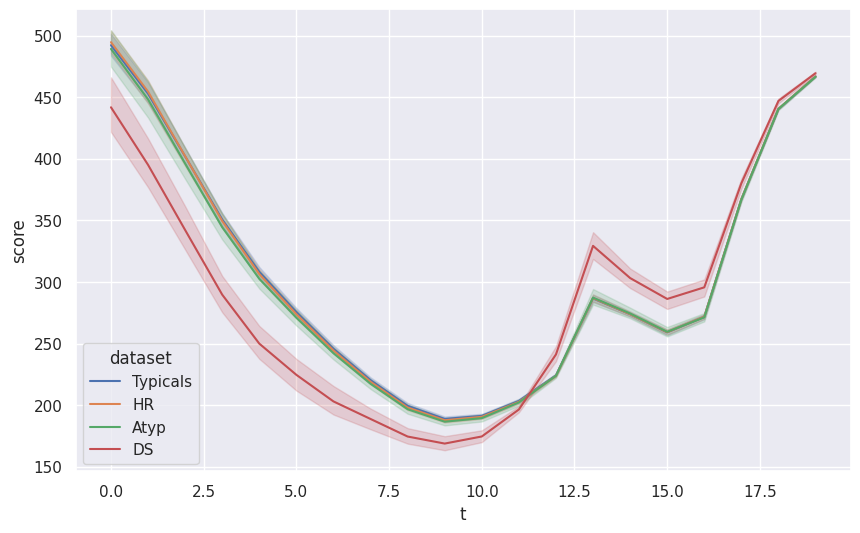

In [20]:
records = [
#     recordify(abcd_eval_score_norms, "ABCD"),
    recordify(ibis_inlier_score_norms, "Typicals"),
    recordify(ibis_hr_inlier_score_norms, "HR"),
    recordify(ibis_atypical_score_norms, "Atyp"),
    recordify(ibis_ds_score_norms, "DS"),
#     recordify(ibis_asd_score_norms, "ASD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

In [8]:
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/ckpt_1500002/smin=0.01_smax=0.80_t=20"

score_file = np.load(f"{workdir}/abcd-train_abcd-val_lesion_load_20-enhanced_results.npz", allow_pickle=True)
abcd_data = np.concatenate([score_file[f] for f in ['eval_score_norms', 'inlier_score_norms']], axis=0)

score_file = np.load(f"{workdir}/abcd-val_abcd-test_lesion_load_20_results.npz", allow_pickle=True)
abcd_data = np.concatenate([abcd_data, score_file['inlier_score_norms']], axis=0)


score_file = np.load(f"{workdir}/ibis-inlier_ibis-hr-inlier_ibis-ds-sa_results.npz", allow_pickle=True)
ibis_typical = np.concatenate([score_file[f] for f in ['eval_score_norms']], axis=0)
ibis_hr_inlier = score_file['inlier_score_norms']
ibis_ds = score_file['ood_score_norms']

score_file = np.load(f"{workdir}/ibis-inlier_ibis-atypical_ibis-asd_results.npz", allow_pickle=True)
ibis_atypical = score_file['inlier_score_norms']
ibis_asd = score_file['ood_score_norms']


datset_list = [abcd_data, ibis_typical, ibis_atypical, ibis_ds]
score_data = np.concatenate(datset_list)
# score_target = np.concatenate([[i]*len(s) for i,s in enumerate(datset_list)], axis=0)
score_target = np.concatenate([[0]*len(abcd_data), [0]*len(ibis_typical), [1]*len(ibis_atypical), [2]*len(ibis_ds)])
abcd_data.shape, ibis_typical.shape, ibis_atypical.shape, ibis_ds.shape, score_data.shape, len(score_target)

((1650, 20), (82, 20), (38, 20), (28, 20), (1798, 20), 1798)

<Axes: xlabel='t', ylabel='score'>

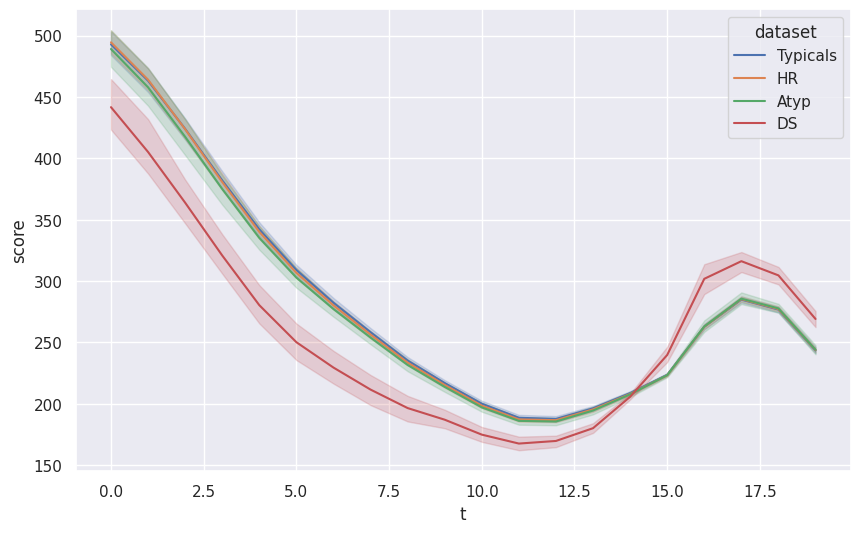

In [9]:
records = [
#     recordify(abcd_data, "ABCD"),
    recordify(ibis_typical, "Typicals"),
    recordify(ibis_hr_inlier, "HR"),
    recordify(ibis_atypical, "Atyp"),
    recordify(ibis_ds, "DS"),
#     recordify(ibis_asd, "ASD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

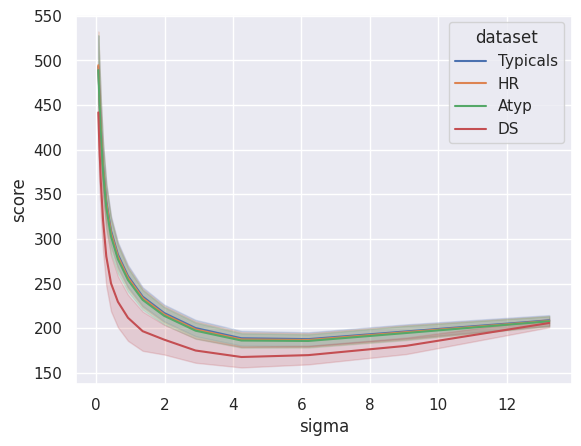

<Axes: xlabel='sigma', ylabel='score'>

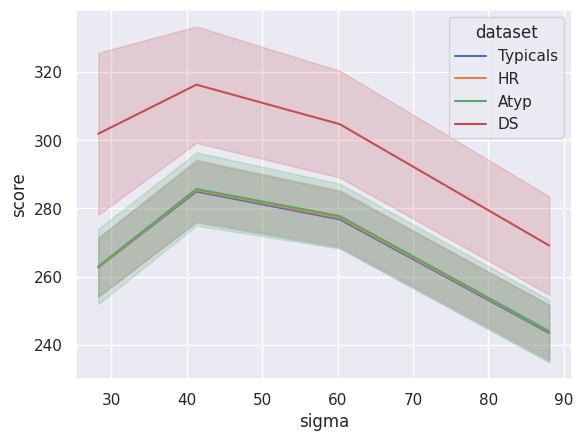

In [10]:
sns.lineplot(data=df.query("t < 15"), x="sigma", y="score", hue="dataset", errorbar=('sd'))
plt.show()
sns.lineplot(data=df.query("t > 15"), x="sigma", y="score", hue="dataset", errorbar=('sd'))

<Axes: xlabel='t', ylabel='score'>

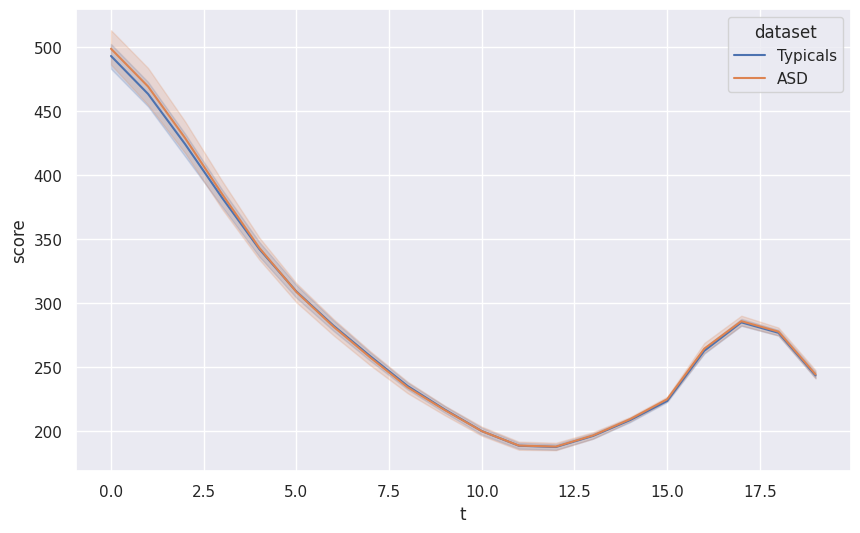

In [11]:
records = [
#     recordify(abcd_data, "ABCD"),
    recordify(ibis_typical, "Typicals"),
#     recordify(ibis_hr_inlier, "HR"),
#     recordify(ibis_atypical, "Atyp"),
#     recordify(ibis_ds, "DS"),
    recordify(ibis_asd, "ASD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

In [13]:
# sns.lineplot(data=df.query("t < 10"), x="t", y="score", hue="dataset", errorbar=('ci', 99))

In [14]:
import re
from sade.configs.ve import biggan_config
from sade.datasets.loaders import get_datasets

config = biggan_config.get_config()
config.eval.experiment.train = "ibis-inlier"
# config.eval.experiment.inlier = "ibis-finetune-hr-train"
config.eval.experiment.inlier = "ibis-hr-inlier"
config.eval.experiment.ood = "ibis-ds-sa"

In [15]:
%%time
ibis_lr_ds, ibis_hr_ds, ibis_ds_ds = get_datasets(config, training=False)

CPU times: user 1.39 ms, sys: 148 µs, total: 1.54 ms
Wall time: 960 µs


In [16]:
ibis_regex = re.compile(r".*IBIS(\d*)\.nii\.gz")
ibis_regex.match(ibis_lr_ds[0]["image"]).group(1)

'108372'

In [17]:
ibis_LR_ids = list(map(lambda x: ibis_regex.match(x["image"]).group(1), ibis_lr_ds))
ibis_HR_ids = list(map(lambda x: ibis_regex.match(x["image"]).group(1), ibis_hr_ds))
ibis_DS_ids = list(map(lambda x: ibis_regex.match(x["image"]).group(1), ibis_ds_ds))

In [18]:
len(ibis_HR_ids)

106

In [19]:
[ibisid in ibis_HR_ids for ibisid in ['214027', '247315', '476634', '540777', '191896', '525057']]

[False, True, True, True, True, True]

In [21]:
ibis_asd.shape

(65, 20)

In [49]:
X_train = ibis_typical
X_test = ibis_hr_inlier
X_ood = [ibis_ds, ibis_atypical, ibis_asd]

results = auxiliary_model_analysis(
    X_train,
    X_test,
    X_ood,
    components_range=range(3, 6, 1),
    labels=["Train", "Inlier", "DS-SA", "Atypicals", "ASD+ve"],
    verbose=0
)

In [50]:
results['GMM']['metrics']

,true_tpr95,fpr_tpr99,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,ap
DS-SA,96.428571,46.226415,28.301887,14.218329,93.194070,83.718761,98.040018,83.932036
Atypicals,94.736842,100.000000,99.056604,42.403178,55.114201,29.482880,73.965979,31.156454
ASD+ve,93.846154,99.056604,93.396226,42.960813,53.425254,42.506151,62.617101,43.148380


In [51]:
X_test.shape

(106, 20)

HR vs DS
----------------
ROC-AUC: 93.1941
PR-AUC (In/Out): 83.7188 / 98.0400
FPR (95% TPR): 28.30%
Detection Error: 14.22%
FPR (99% TPR): 46.23%
HR vs ASD+ve
----------------
ROC-AUC: 53.4253
PR-AUC (In/Out): 42.5062 / 62.6171
FPR (95% TPR): 93.40%
Detection Error: 42.96%
FPR (99% TPR): 99.06%


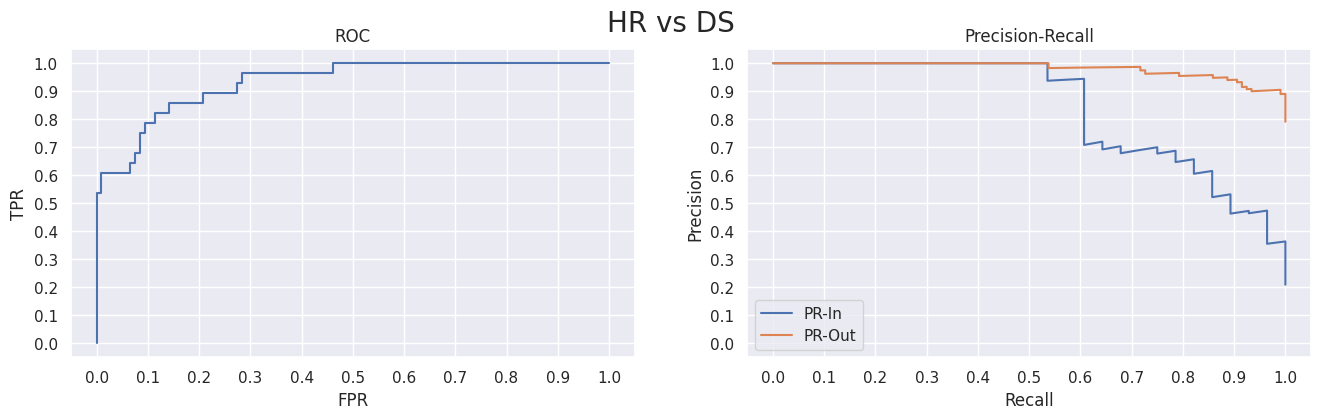

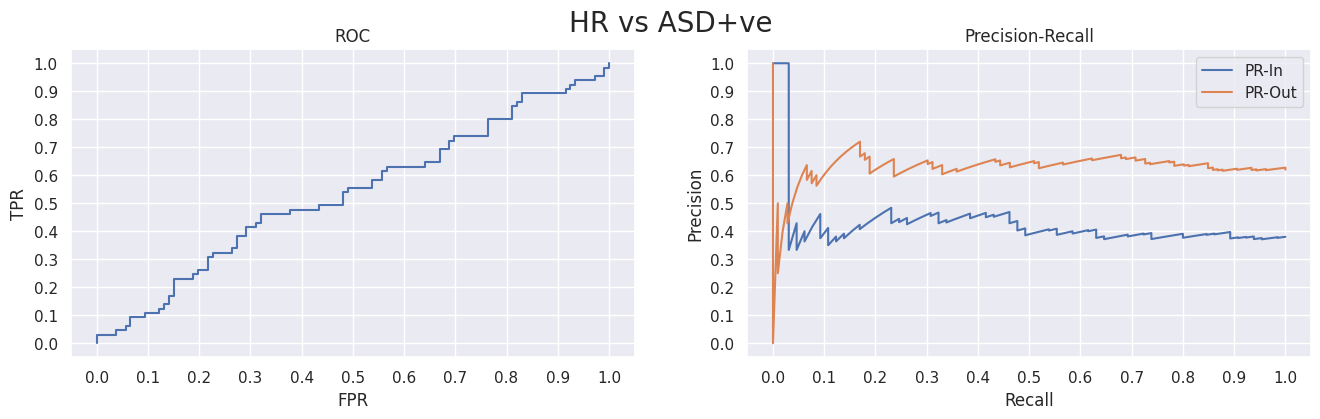

In [52]:
from sade.ood_detection_helper import ood_metrics

_ = ood_metrics(results['GMM']['test_scores'], results['GMM']['ood_scores'][0], plot=True, verbose=True, names=["HR", "DS"])
_ = ood_metrics(results['GMM']['test_scores'], results['GMM']['ood_scores'][-1], plot=True, verbose=True, names=["HR", "ASD+ve"])

In [36]:
# results['GMM']['ood_scores']

In [29]:
sorted_idxs = results['GMM']['test_scores'].argsort()
[ibis_HR_ids[x] for x in sorted_idxs[:6]]

['247315', '525057', '476634', '540777', '191896', '788407']

In [30]:
[ibis_HR_ids[x] for x in results['KD Tree']['test_scores'].argsort()[::-1][:6]]

['191896', '247315', '823104', '769118', '788407', '476634']

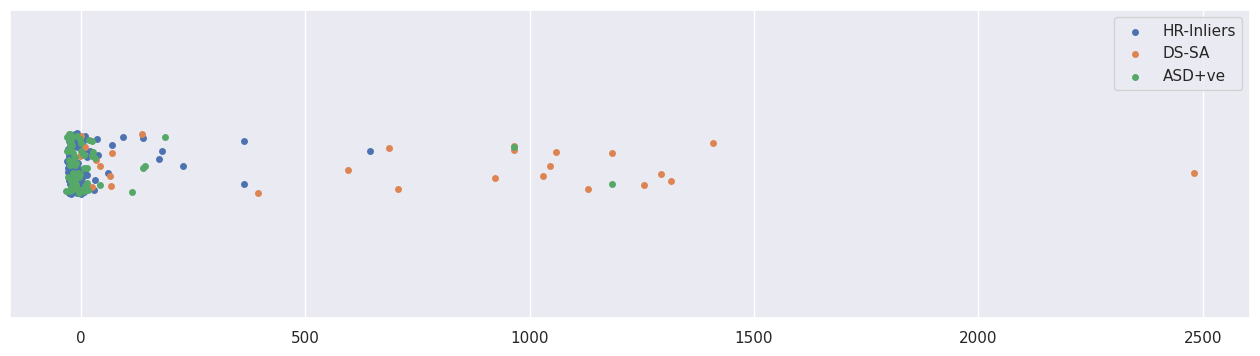

In [53]:
plt.subplots(1,1, figsize=(16,4))
sns.stripplot(results['GMM']['test_scores'], label="HR-Inliers", orient="h")
sns.stripplot(results['GMM']['ood_scores'][0], label="DS-SA",  orient="h")
# sns.stripplot(results['GMM']['ood_scores'][1], label="Borderline",  orient="h")
sns.stripplot(results['GMM']['ood_scores'][2], label="ASD+ve",  orient="h")

plt.legend()

In [95]:
# %%time

N_TRIALS = 100
NUM_SAMPLES = 50

models = ["GMM", "KD Tree", "KDE"]
metric_names = ["ap", "fpr_tpr95", "fpr_tpr99", "roc_auc", "de"]

# create a MultiIndex with the product of the model names and metrics
index = pd.MultiIndex.from_product([["Ensemble"]+models, list(map(str.upper, metric_names))]
                                   , names=['Model', 'Metric'])

# create an empty DataFrame with the MultiIndex
comb_metrics_df = pd.DataFrame(index=index, columns=np.arange(N_TRIALS), dtype=np.float32)

np.random.seed(42)
for i in tqdm(range(N_TRIALS)):
#     train_set_inliers = np.random.permutation(abcd_data[-300:])
    test_set_inliers = np.random.permutation(ibis_typical)

    X_train = np.concatenate((ibis_hr_inlier,
                              ibis_atypical,
                              test_set_inliers[:NUM_SAMPLES]), axis=0)

    X_test = test_set_inliers[NUM_SAMPLES:]
    X_ood = [ibis_ds]

    m = auxiliary_model_analysis(
        X_train,
        X_test,
        X_ood,
        components_range=range(3, 6, 1),
        labels=["Train", "Inlier", "OOD"],
        flow_epochs=-1,
        kde=True,
        verbose=0
    )
    
    for name in models:
        comb_metrics_df.loc[(name,), i] = m[name]["metrics"][metric_names].iloc[0].values
        
    inlier_ensemble_ll = m["GMM"]["test_scores"] + m["KDE"]["test_scores"]
    ood_ensemble_ll = m["GMM"]["ood_scores"][0] + m["KDE"]["ood_scores"][0]
    m=get_metrics(inlier_ensemble_ll, [ood_ensemble_ll], labels=["Train", "Inlier", "OOD"])
    comb_metrics_df.loc[("Ensemble",), i] = m[metric_names].iloc[0].values

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


In [96]:
stats = multi_df_stats(comb_metrics_df, index)
stats

median       mean        std
Model    Metric                                    
Ensemble AP         94.848715  94.833169   1.307561
         FPR_TPR95  21.875000  22.625000   6.559869
         FPR_TPR99  50.000000  49.343750  11.945523
         ROC_AUC    94.642857  94.651786   1.397370
         DE         11.383929  11.334821   2.514513
GMM      AP         94.320010  94.336553   1.798698
         FPR_TPR95  28.125000  27.250000   9.243394
         FPR_TPR99  34.375000  33.562500   9.259814
         ROC_AUC    94.363839  94.261161   2.089013
         DE         12.500000  12.008929   2.875915
KD Tree  AP         93.992234  93.976524   1.591984
         FPR_TPR95  15.625000  16.843750   5.581252
         FPR_TPR99  96.875000  91.937500   9.610674
         ROC_AUC    93.359375  93.186384   1.458493
         DE          9.598214   9.955357   2.593807
KDE      AP         92.948552  92.824949   1.587176
         FPR_TPR95  29.687500  31.156250   7.291058
         FPR_TPR99  96.875000  97.687500   2.248211
         ROC_AUC    91.964286  91.746652   1.510450
         DE         11.383929  12.348214   2.659126

In [97]:
df = comb_metrics_df.reset_index()
df_long = df.melt(id_vars=["Model", "Metric"], var_name="Run")

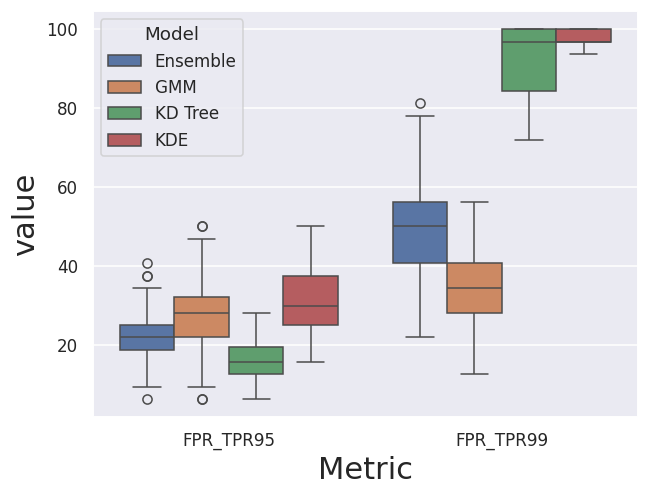

In [98]:
fig = sns.boxplot(data=df_long.query("Metric == 'FPR_TPR95' | Metric == 'FPR_TPR99'"), x='Metric', y='value', hue='Model',)

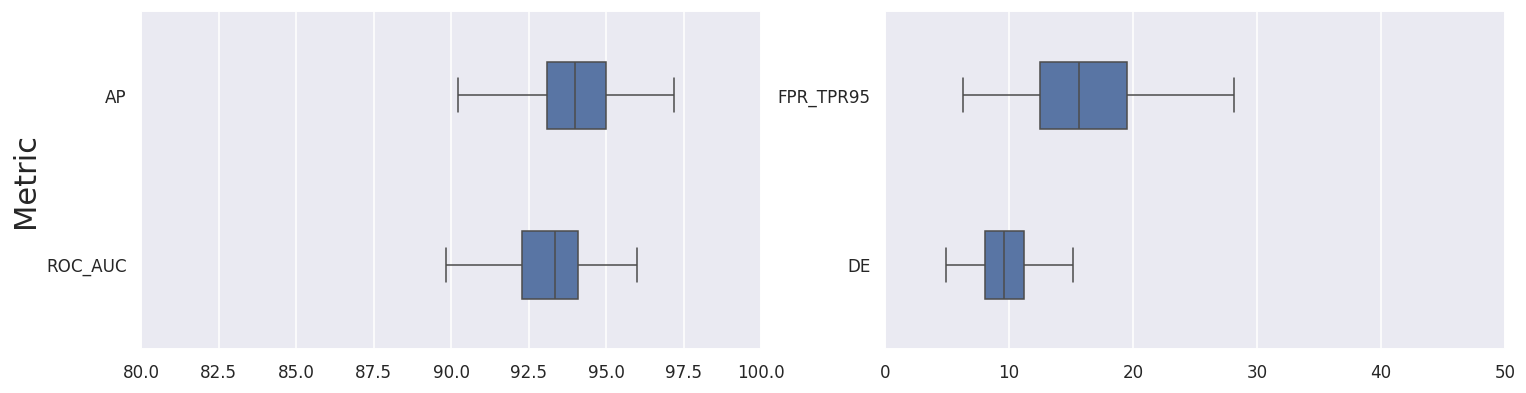

In [103]:
melted = comb_metrics_df.loc["KD Tree"].reset_index()
melted = melted.melt(id_vars=["Metric"], var_name="Run")
sns.set_theme(rc={'figure.dpi':110, 'axes.labelsize':20})
fig,axs = plt.subplots(1,2, figsize=(16,4),)

sns.boxplot(data=melted.query("Metric == 'ROC_AUC' | Metric == 'AP'"),
                  y='Metric', x='value',ax=axs[0], orient="h", width=0.4)

sns.boxplot(data=melted.query("Metric == 'FPR_TPR95' | Metric == 'DE'"),
                  y='Metric', x='value', orient="h", ax=axs[1], width=0.4)

axs[0].set_xlim(80, 100);
axs[1].set_xlim(0, 50);

axs[1].set_ylabel(None);
axs[0].set_xlabel(None);
axs[1].set_xlabel(None);

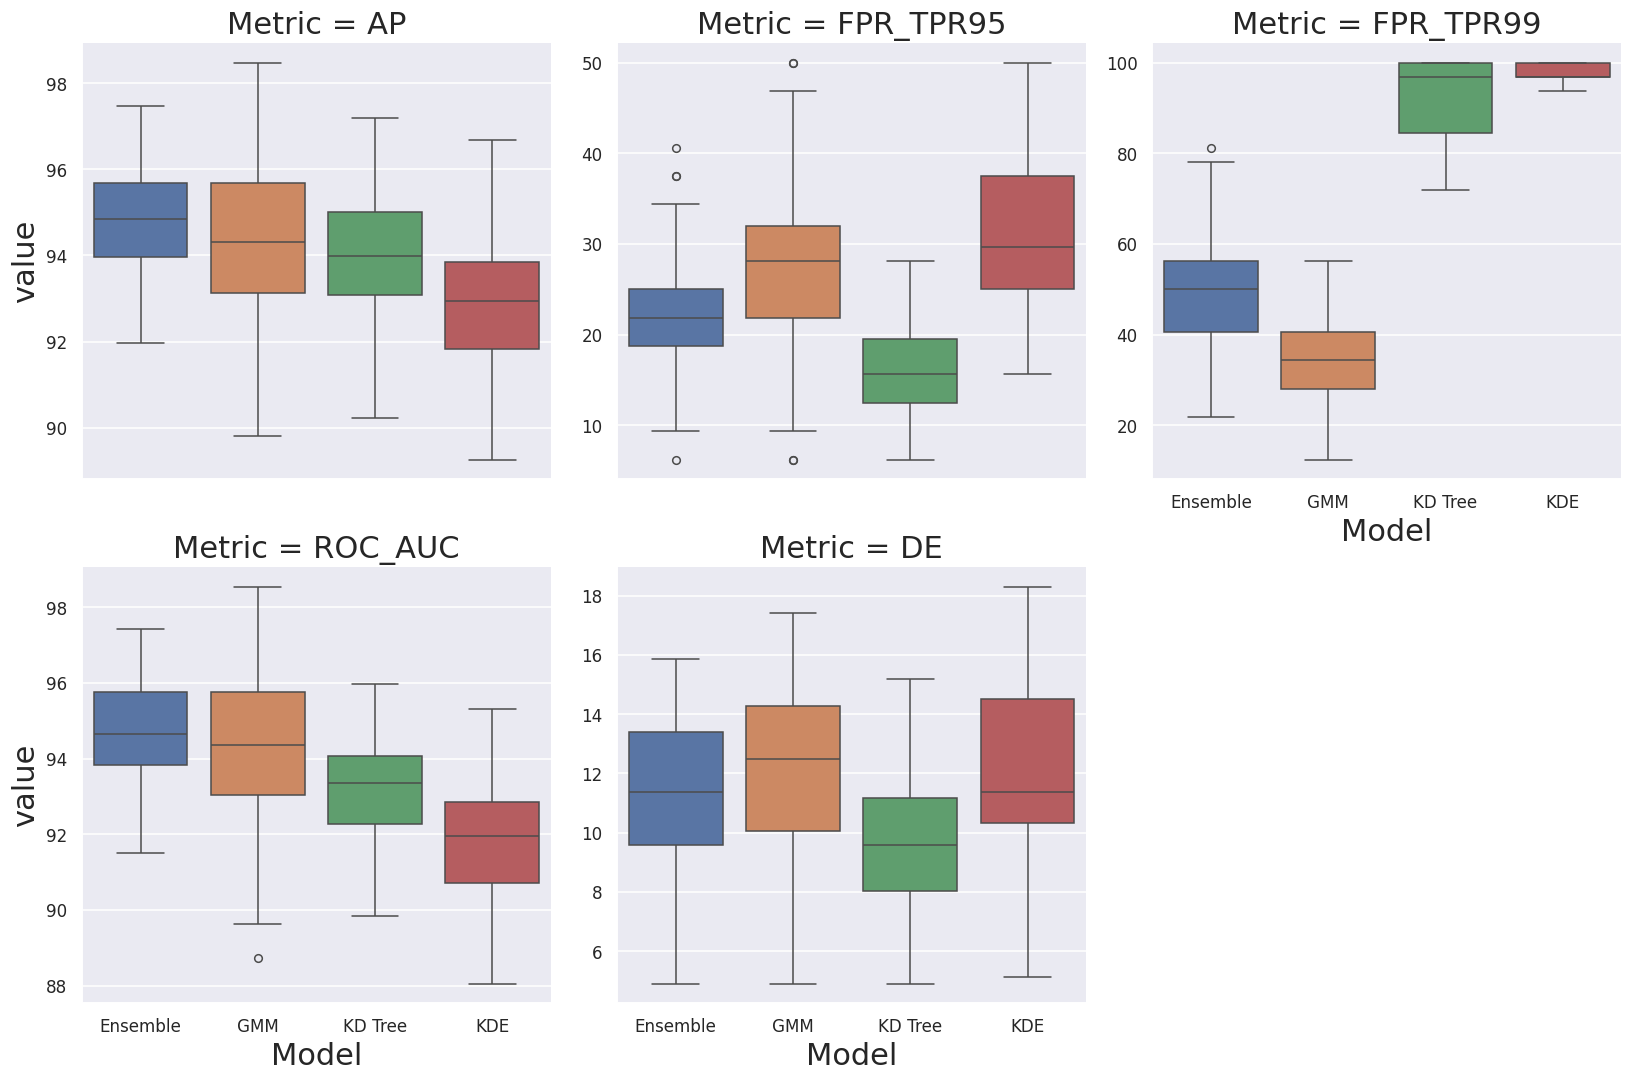

In [100]:
fig = sns.catplot(data=df_long, x='Model', y='value', kind="box",
                  hue='Model', col='Metric', col_wrap=3, errorbar="se",
                  sharey=False)

### IBIS Finetuned

In [15]:
exp = "abcd-val_ibis-inlier_lesion_load_20"
fname=f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/finetune/fast-hr-only/eval/ckpt_200020/{exp}_results.npz"

with np.load(fname, allow_pickle=True) as data:
    eval_score_norms = data["eval_score_norms"]
    inlier_score_norms = data["inlier_score_norms"]
    ood_score_norms = data["ood_score_norms"]


eval_score_norms.shape, inlier_score_norms.shape, ood_score_norms.shape

((165, 20), (86, 20), (86, 20))

<Axes: xlabel='t', ylabel='score'>

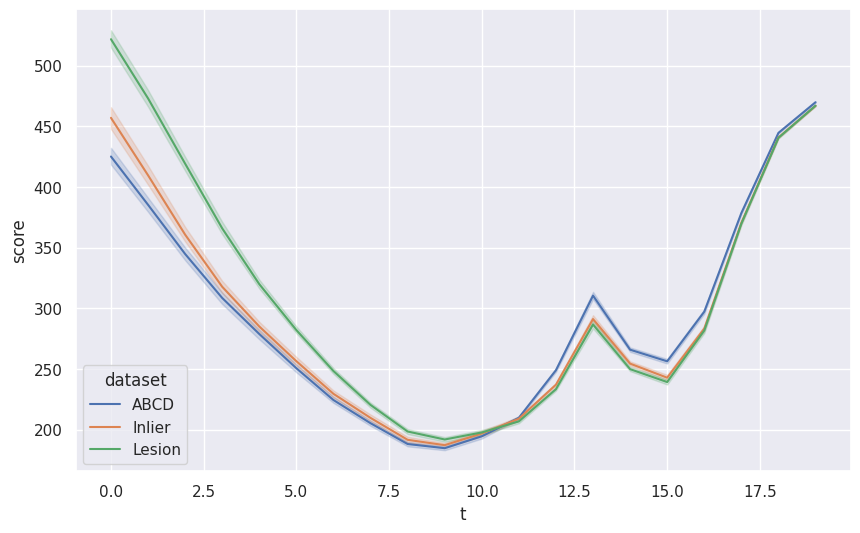

In [23]:
records = [
    recordify(eval_score_norms, "ABCD"),
    recordify(inlier_score_norms, "Inlier"),
    recordify(ood_score_norms, "Lesion"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

<Axes: xlabel='t', ylabel='score'>

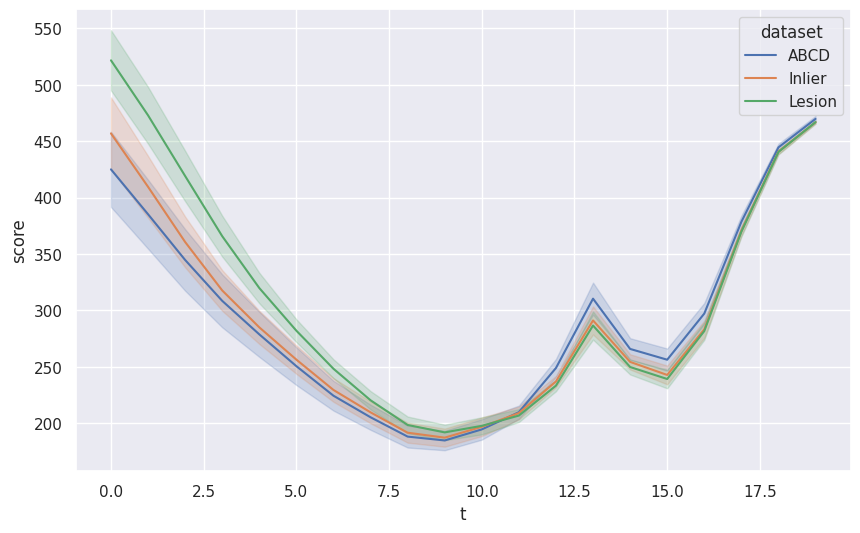

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('sd'), ax=ax)
# plt.ylim(100,None)

In [19]:
eval_score_norms.shape, inlier_score_norms.shape, ood_score_norms.shape

((165, 20), (86, 20), (86, 20))

In [20]:
X_train = eval_score_norms
X_test = inlier_score_norms
X_ood = [ood_score_norms]

results = auxiliary_model_analysis(
    X_train,
    X_test,
    X_ood,
    components_range=range(3, 6, 1),
    labels=["Train", "Inlier", "OOD"],
    verbose=0
)

In [21]:
results['GMM']['metrics']

,ap,de,fpr_tpr95,fpr_tpr99,pr_auc_in,pr_auc_out,roc_auc,true_tpr95
OOD,92.475379,9.302326,12.790698,20.930233,92.413822,95.449262,93.861547,93.023256


In [ ]:
%%time

N_TRIALS = 10
NUM_SAMPLES = 20

models = ["GMM", "KD Tree"]
metric_names = ["ap", "fpr_tpr95", "fpr_tpr99", "roc_auc", "de"]

# create a MultiIndex with the product of the model names and metrics
index = pd.MultiIndex.from_product([models, list(map(str.upper, metric_names))]
                                   , names=['Model', 'Metric'])

# create an empty DataFrame with the MultiIndex
comb_metrics_df = pd.DataFrame(index=index, columns=np.arange(N_TRIALS), dtype=np.float32)

np.random.seed(42)
for i in tqdm(range(N_TRIALS)):
#     train_set_inliers = np.random.permutation(eval_score_norms)
    test_set_inliers = np.random.permutation(inlier_score_norms)

    X_train = np.concatenate((eval_score_norms,
                              test_set_inliers[:NUM_SAMPLES]), axis=0)

    X_test = test_set_inliers[NUM_SAMPLES:]
    X_ood = [ood_score_norms]

    m = auxiliary_model_analysis(
        X_train,
        X_test,
        X_ood,
        components_range=range(3, 6, 1),
        labels=["Train", "Inlier", "OOD"],
        flow_epochs=1,
        verbose=0
    )
    
    for name in models:
        comb_metrics_df.loc[(name,), i] = m[name]["metrics"][metric_names].iloc[0].values

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

inlier_score = m["KD Tree"]["test_scores"]
outlier_score = m["KD Tree"]["ood_scores"][0]

y_true = np.concatenate((np.zeros(len(inlier_score)), np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))

prec_in, rec_in, _ = precision_recall_curve(y_true, y_scores)

# Outliers are treated as "positive" class
# i.e label 1 is now label 0
prec_out, rec_out, _ = precision_recall_curve((y_true == 0), -y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores, drop_intermediate=False)

In [ ]:
tpr[30], fpr[30]

In [ ]:
t = thresholds[30]
t

In [ ]:
len(y_scores[-28:])

In [ ]:
anos = y_scores[:40][y_scores[:40] >= t]
len(anos)

In [ ]:
5/40